<a href="https://colab.research.google.com/github/alifabdullah/DataScience/blob/main/BUSI_project_VIT_UNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###All library



In [ ]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import resample
# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pretrained models
import timm

# Kaggle dataset utility
import kagglehub


###### Import Dataset

In [ ]:
# Custom Dataset for Breast Ultrasound Images
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, img_size=224):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Resize images
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')  # Grayscale
        img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


###Train Model

In [ ]:
# Function to train the model
def train(model, loader, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    criterion = nn.CrossEntropyLoss()

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Function to validate the model
def validate(model, loader, device):
    model.eval()
    total_loss, correct = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


###Download Data

In [ ]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
print("Path to dataset files:", path)

data_dir = os.path.join(path, "Dataset_BUSI_with_GT")

# Get class folders and image paths
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
filepaths, labels = [], []

for i, c in enumerate(classes):
    class_dir = os.path.join(data_dir, c)
    for f in os.listdir(class_dir):
        if f.endswith('.png') and 'mask' not in f:
            filepaths.append(os.path.join(class_dir, f))
            labels.append(i)

# Split into train and validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels
)

# Create Dataset and DataLoader
train_ds = UltrasoundDataset(train_imgs, train_labels)
val_ds = UltrasoundDataset(val_imgs, val_labels)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


100%|██████████| 195M/195M [00:09<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1


### ViT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ViT model with grayscale input
model = timm.create_model('vit_base_patch16_224', pretrained=True, in_chans=1, num_classes=len(classes))
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
### Run Model

In [ ]:
# Store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20 # Increased epochs from 10 to 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, device)

    print(f'Epoch {epoch+1}: train_acc={train_acc:.4f} val_acc={val_acc:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Save the trained model
torch.save(model.state_dict(), 'vit_breast_ultrasound.pth')

Epoch 1: train_acc=0.6426 val_acc=0.7436
Epoch 2: train_acc=0.7660 val_acc=0.8141
Epoch 3: train_acc=0.8349 val_acc=0.7949
Epoch 4: train_acc=0.9231 val_acc=0.8846
Epoch 5: train_acc=0.9487 val_acc=0.8974
Epoch 6: train_acc=0.9519 val_acc=0.8846
Epoch 7: train_acc=0.9599 val_acc=0.8718
Epoch 8: train_acc=0.9744 val_acc=0.8782
Epoch 9: train_acc=0.9679 val_acc=0.8654
Epoch 10: train_acc=0.9663 val_acc=0.8654
Epoch 11: train_acc=0.9567 val_acc=0.8077
Epoch 12: train_acc=0.9792 val_acc=0.8846
Epoch 13: train_acc=0.9904 val_acc=0.8782
Epoch 14: train_acc=0.9824 val_acc=0.8846
Epoch 15: train_acc=0.9872 val_acc=0.8718
Epoch 16: train_acc=0.9888 val_acc=0.9038
Epoch 17: train_acc=0.9952 val_acc=0.9103
Epoch 18: train_acc=0.9920 val_acc=0.8526
Epoch 19: train_acc=0.9808 val_acc=0.8846
Epoch 20: train_acc=0.9904 val_acc=0.9167


###Accuracy and Loss

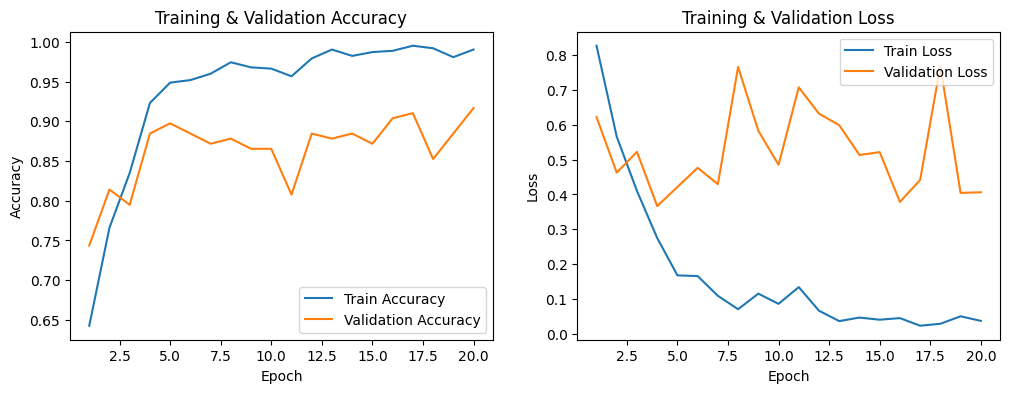

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


###Classification Report

###Confution Metrix

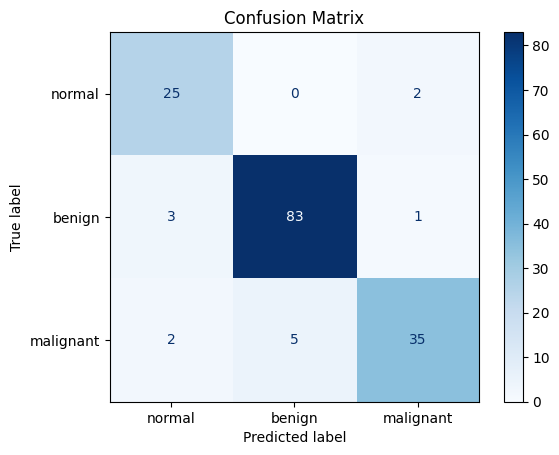



Classification Report:
              precision    recall  f1-score   support

      normal       0.83      0.93      0.88        27
      benign       0.94      0.95      0.95        87
   malignant       0.92      0.83      0.88        42

    accuracy                           0.92       156
   macro avg       0.90      0.90      0.90       156
weighted avg       0.92      0.92      0.92       156



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Evaluate on validation set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=classes)
print("\n\nClassification Report:")
print(report)

####SEGMENTATION (UNET)

###Data loading and process

In [ ]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("sabahesaraki/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


In [ ]:
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
tumor_typ = ["benign", "malignant", "normal"]

In [ ]:
image_path = []
mask_path = []
labels = []

for tumor in tumor_typ:
  folder = os.path.join(path,tumor)
  if os.path.exists(folder):
    files = os.listdir(folder)
    images_file = [idx for idx in files if idx.endswith('.png') and '_mask' not in idx]
    for image_file in images_file:
      mask_file = image_file.replace('.png','_mask.png')
      image_full_path = os.path.join(folder,image_file)
      mask_full_path = os.path.join(folder,mask_file)

      if os.path.exists(image_full_path) and os.path.exists(mask_full_path):
        image_path.append(image_full_path)
        mask_path.append(mask_full_path)
        labels.append(tumor)

      else:
        print(f"Missing pair for image: {image_full_path} or mask: {mask_full_path}")
  else:
        print(f"Folder not found: {folder}")


df = pd.DataFrame({
    "image_path": image_path,
    "mask_path": mask_path,
    "tumor_type": labels
})

In [ ]:
df

,image_path,mask_path,tumor_type
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
...,...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
776,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
777,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
778,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal


In [ ]:
df.head(5)

,image_path,mask_path,tumor_type
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  780 non-null    object
 1   mask_path   780 non-null    object
 2   tumor_type  780 non-null    object
dtypes: object(3)
memory usage: 18.4+ KB


In [ ]:
df.shape

(780, 3)

In [ ]:
df['tumor_type'].value_counts()

,count
tumor_type,
benign,437
malignant,210
normal,133


In [ ]:
from PIL import Image


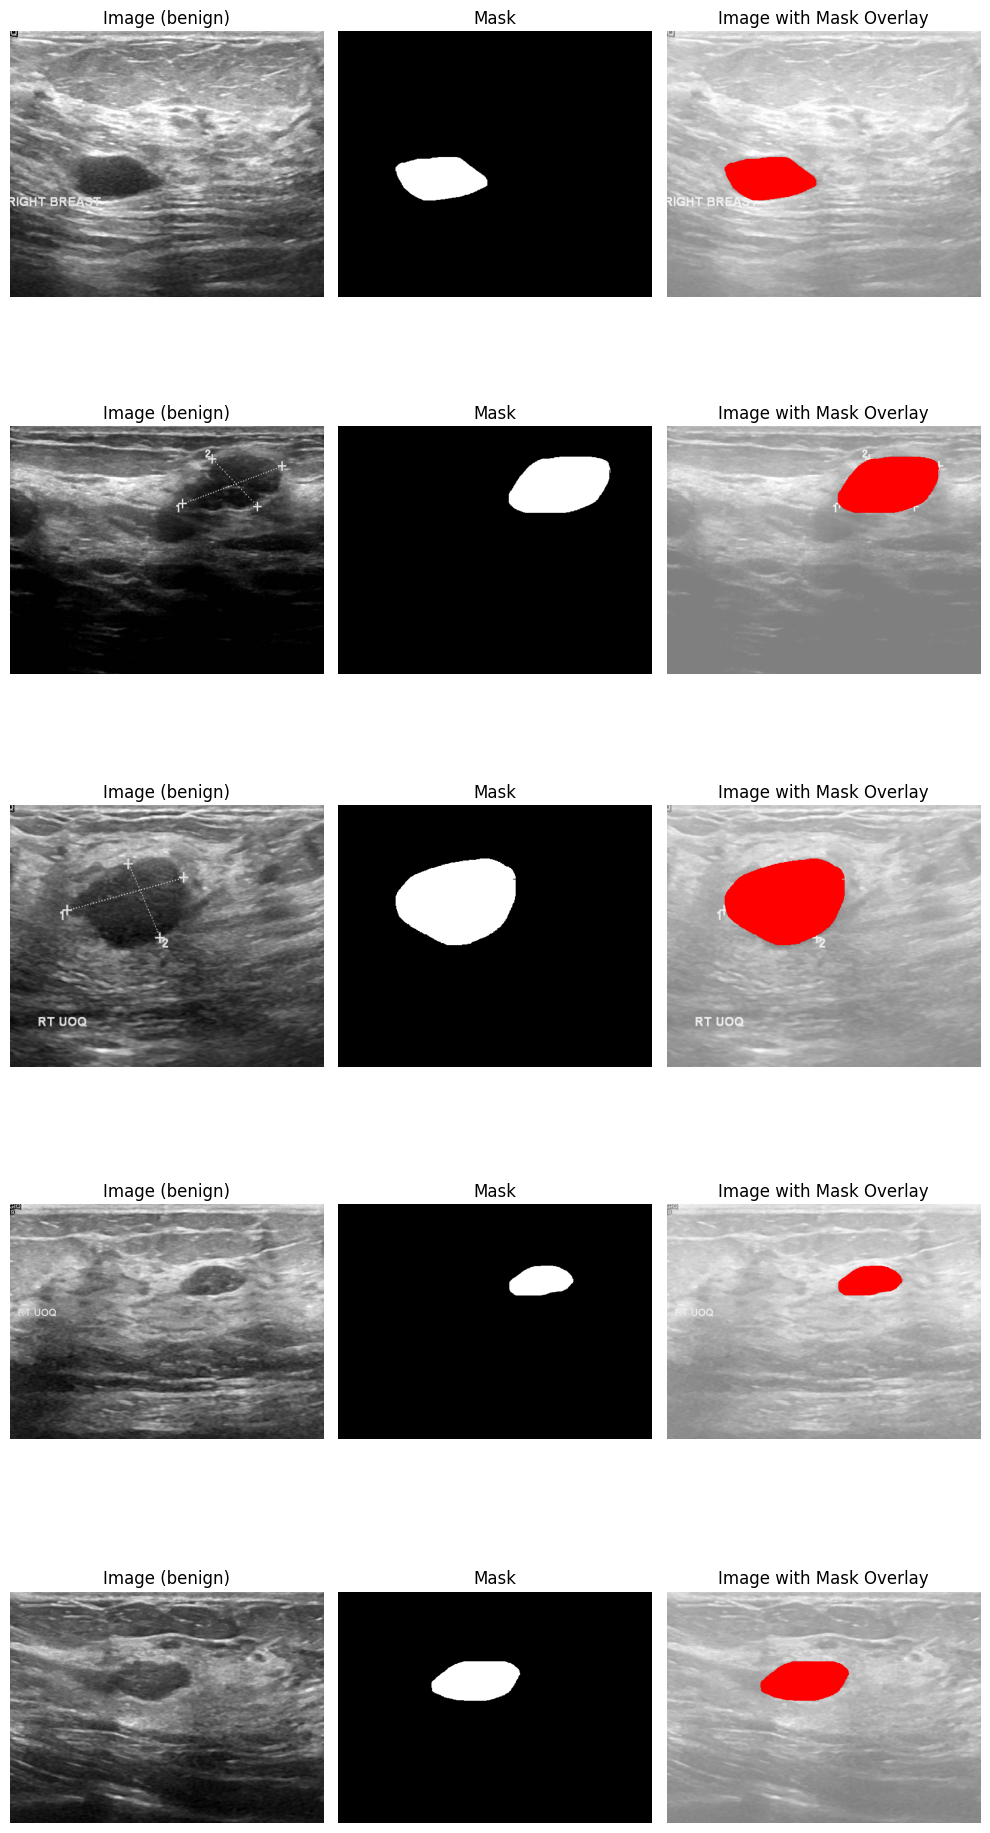

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images_with_masks(df, num_images=5):
    """
    Displays a specified number of images, their masks, and tumor types from the dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing 'image_path', 'mask_path', and 'tumor_type'.
        num_images (int): The number of images to display.
    """
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 4))
    if num_images == 1: # Handle the case of a single image
        axes = [axes]

    for i in range(num_images):
        if i >= len(df):
            print(f"Only {len(df)} images available. Displaying all available images.")
            break

        row = df.iloc[i]
        image_path = row['image_path']
        mask_path = row['mask_path']
        tumor_type = row['tumor_type']

        try:
            image = Image.open(image_path).convert('RGB') # Convert to RGB for consistent display
            mask = Image.open(mask_path).convert('L') # Convert mask to grayscale

            axes[i][0].imshow(image)
            axes[i][0].set_title(f"Image ({tumor_type})")
            axes[i][0].axis('off')

            axes[i][1].imshow(mask, cmap='gray') # Display mask in grayscale
            axes[i][1].set_title("Mask")
            axes[i][1].axis('off')

            # Overlay mask on image
            overlay = image.copy()
            overlay.putalpha(128) # Add transparency
            mask_colored = Image.new('RGB', image.size, color='red') # You can choose a different color
            mask_colored.putalpha(mask)

            combined = Image.alpha_composite(overlay, mask_colored)

            axes[i][2].imshow(combined)
            axes[i][2].set_title("Image with Mask Overlay")
            axes[i][2].axis('off')


        except FileNotFoundError:
            print(f"Error: File not found for image: {image_path} or mask: {mask_path}")
        except Exception as e:
            print(f"An error occurred while processing image {image_path}: {e}")


    plt.tight_layout()
    plt.show()

# Display the first 5 images with their masks and tumor types
display_images_with_masks(df, num_images=5)

###Balance the Dataset


In [ ]:
df_benign = df[df["tumor_type"] == "benign"]
df_malignant = df[df["tumor_type"] == "malignant"]
df_normal = df[df["tumor_type"] == "normal"]

max_size = max(len(df_benign), len(df_malignant), len(df_normal))

🧪 Purpose: Balance the Dataset for Fair Training
Breast ultrasound images are categorized into three classes:

Benign

Malignant

Normal

These classes are often imbalanced—some have far fewer samples than others. Training a model on such data can lead to biased predictions.

In [ ]:
df_malignant_oversampled = resample(df_malignant,
                                     replace=True,
                                     n_samples=max_size,
                                     random_state=42)
df_normal_oversampled = resample(df_normal,
                                    replace=True,
                                    n_samples=max_size,
                                    random_state=42)

In [ ]:
df_balanced = pd.concat([df_benign, df_malignant_oversampled, df_normal_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("\nBalanced Distribution:")
print(df_balanced["tumor_type"].value_counts())


Balanced Distribution:
tumor_type
normal       437
benign       437
malignant    437
Name: count, dtype: int64


In [ ]:
df = df_balanced

In [ ]:
df

,image_path,mask_path,tumor_type
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,malignant
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
...,...,...,...
1306,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1307,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1308,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1309,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,malignant


In [ ]:
df

,image_path,mask_path,tumor_type
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,malignant
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,benign
...,...,...,...
1306,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1307,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1308,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,normal
1309,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...,malignant


###Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downsampling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

###Testing

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the U-Net model
# Assuming n_channels=1 for grayscale input and n_classes=1 for binary segmentation (mask)
model = UNet(n_channels=1, n_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy with Logits for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 50 # Define the number of epochs
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

print("Training finished!")

# Optionally save the trained model
torch.save(model.state_dict(), 'unet_breast_segmentation.pth')

Epoch 1/50 - Validation: 100%|██████████| 33/33 [00:08<00:00,  3.84it/s]


Epoch 1/50, Train Loss: 0.3499, Val Loss: 0.2903


Epoch 2/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.78it/s]


Epoch 2/50, Train Loss: 0.2531, Val Loss: 0.2353


Epoch 3/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.51it/s]


Epoch 3/50, Train Loss: 0.2127, Val Loss: 0.2015


Epoch 4/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]


Epoch 4/50, Train Loss: 0.1846, Val Loss: 0.1822


Epoch 5/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.80it/s]


Epoch 5/50, Train Loss: 0.1653, Val Loss: 0.2136


Epoch 6/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]


Epoch 6/50, Train Loss: 0.1461, Val Loss: 0.1543


Epoch 7/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 7/50, Train Loss: 0.1360, Val Loss: 0.1446


Epoch 8/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]


Epoch 8/50, Train Loss: 0.1209, Val Loss: 0.1369


Epoch 9/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]


Epoch 9/50, Train Loss: 0.1116, Val Loss: 0.1417


Epoch 10/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]


Epoch 10/50, Train Loss: 0.1033, Val Loss: 0.1146


Epoch 11/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.75it/s]


Epoch 11/50, Train Loss: 0.0986, Val Loss: 0.1216


Epoch 12/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]


Epoch 12/50, Train Loss: 0.0880, Val Loss: 0.1134


Epoch 13/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 13/50, Train Loss: 0.0793, Val Loss: 0.1012


Epoch 14/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.80it/s]


Epoch 14/50, Train Loss: 0.0761, Val Loss: 0.1041


Epoch 15/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.69it/s]


Epoch 15/50, Train Loss: 0.0716, Val Loss: 0.1032


Epoch 16/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]


Epoch 16/50, Train Loss: 0.0650, Val Loss: 0.0977


Epoch 17/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]


Epoch 17/50, Train Loss: 0.0595, Val Loss: 0.0868


Epoch 18/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.81it/s]


Epoch 18/50, Train Loss: 0.0570, Val Loss: 0.0884


Epoch 19/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 19/50, Train Loss: 0.0561, Val Loss: 0.0840


Epoch 20/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]


Epoch 20/50, Train Loss: 0.0479, Val Loss: 0.0808


Epoch 21/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.52it/s]


Epoch 21/50, Train Loss: 0.0433, Val Loss: 0.0745


Epoch 22/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 22/50, Train Loss: 0.0463, Val Loss: 0.0997


Epoch 23/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]


Epoch 23/50, Train Loss: 0.0388, Val Loss: 0.0714


Epoch 24/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.82it/s]


Epoch 24/50, Train Loss: 0.0340, Val Loss: 0.0755


Epoch 25/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]


Epoch 25/50, Train Loss: 0.0305, Val Loss: 0.0738


Epoch 26/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.52it/s]


Epoch 26/50, Train Loss: 0.0289, Val Loss: 0.0774


Epoch 27/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.72it/s]


Epoch 27/50, Train Loss: 0.0277, Val Loss: 0.0781


Epoch 28/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.50it/s]


Epoch 28/50, Train Loss: 0.0277, Val Loss: 0.0802


Epoch 29/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]


Epoch 29/50, Train Loss: 0.0242, Val Loss: 0.0734


Epoch 30/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.80it/s]


Epoch 30/50, Train Loss: 0.0223, Val Loss: 0.0717


Epoch 31/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.74it/s]


Epoch 31/50, Train Loss: 0.0208, Val Loss: 0.0705


Epoch 32/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]


Epoch 32/50, Train Loss: 0.0229, Val Loss: 0.0676


Epoch 33/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]


Epoch 33/50, Train Loss: 0.0193, Val Loss: 0.0868


Epoch 34/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.84it/s]


Epoch 34/50, Train Loss: 0.0373, Val Loss: 0.0943


Epoch 35/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.60it/s]


Epoch 35/50, Train Loss: 0.0287, Val Loss: 0.0735


Epoch 36/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]


Epoch 36/50, Train Loss: 0.0199, Val Loss: 0.0772


Epoch 37/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.87it/s]


Epoch 37/50, Train Loss: 0.0180, Val Loss: 0.0774


Epoch 38/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.76it/s]


Epoch 38/50, Train Loss: 0.0159, Val Loss: 0.0724


Epoch 39/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]


Epoch 39/50, Train Loss: 0.0157, Val Loss: 0.0708


Epoch 40/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]


Epoch 40/50, Train Loss: 0.0145, Val Loss: 0.0762


Epoch 41/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.51it/s]


Epoch 41/50, Train Loss: 0.0130, Val Loss: 0.0746


Epoch 42/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.54it/s]


Epoch 42/50, Train Loss: 0.0125, Val Loss: 0.0763


Epoch 43/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


Epoch 43/50, Train Loss: 0.0117, Val Loss: 0.0793


Epoch 44/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.86it/s]


Epoch 44/50, Train Loss: 0.0130, Val Loss: 0.0767


Epoch 45/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.80it/s]


Epoch 45/50, Train Loss: 0.0119, Val Loss: 0.0751


Epoch 46/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.64it/s]


Epoch 46/50, Train Loss: 0.0111, Val Loss: 0.0787


Epoch 47/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]


Epoch 47/50, Train Loss: 0.0374, Val Loss: 0.0943


Epoch 48/50 - Validation: 100%|██████████| 33/33 [00:06<00:00,  4.81it/s]


Epoch 48/50, Train Loss: 0.0253, Val Loss: 0.0766


Epoch 49/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]


Epoch 49/50, Train Loss: 0.0276, Val Loss: 0.0892


Epoch 50/50 - Validation: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]


Epoch 50/50, Train Loss: 0.0179, Val Loss: 0.0778
Training finished!


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, df, img_size=256):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]) # Assuming grayscale images
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('L') # Grayscale
        mask = Image.open(mask_path).convert('L')  # Grayscale

        image = self.transform(image)
        mask = self.mask_transform(mask)

        return image, mask

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create dataset and dataloaders
img_size = 256 # Define image size for segmentation
train_dataset = SegmentationDataset(train_df, img_size=img_size)
val_dataset = SegmentationDataset(val_df, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

Pixel-wise Accuracy: 0.9828

Pixel-wise Confusion Matrix:
[[15806412   110838]
 [  185948  1132770]]


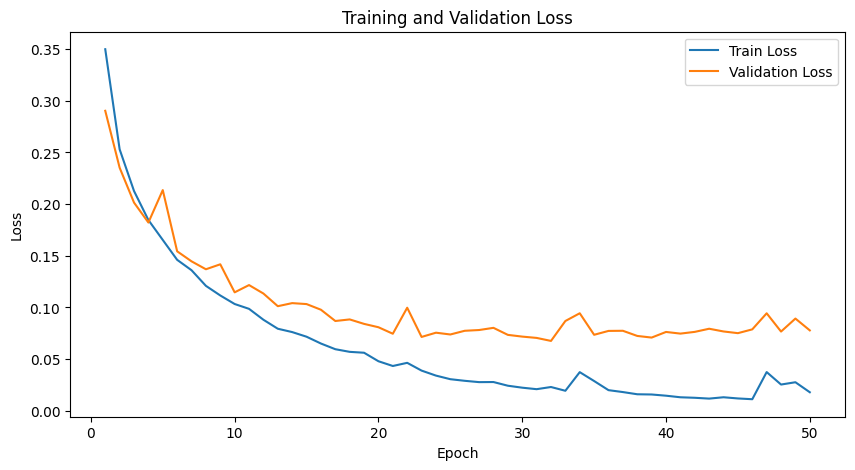

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_masks = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)
        # Apply sigmoid to get probabilities and threshold to get binary mask
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())

        # Binarize the true masks and convert to integer type
        binarized_masks = (masks > 0.5).int() # Assuming mask values are 0 or 255, or normalized between 0-1
        all_masks.append(binarized_masks.cpu().numpy())


# Concatenate all predictions and masks
all_preds = np.concatenate(all_preds).flatten()
all_masks = np.concatenate(all_masks).flatten()

# Calculate pixel-wise accuracy
accuracy = accuracy_score(all_masks, all_preds)
print(f"Pixel-wise Accuracy: {accuracy:.4f}")

# Calculate pixel-wise confusion matrix
cm = confusion_matrix(all_masks, all_preds)
print("\nPixel-wise Confusion Matrix:")
print(cm)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import torch

def iou_score(pred_mask, true_mask):
    """
    Calculates the Intersection over Union (IoU) score for a single mask.
    """
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    if union == 0:
        return 0.0  # Avoid division by zero if there's no ground truth or prediction
    return intersection / union

def dice_score(pred_mask, true_mask):
    """
    Calculates the Dice Coefficient for a single mask.
    """
    intersection = np.logical_and(pred_mask, true_mask).sum()
    # Add a check for the sum of masks to avoid division by zero
    sum_masks = pred_mask.sum() + true_mask.sum()
    if sum_masks == 0:
        return 0.0 # Or 1.0 depending on convention for empty masks
    return (2. * intersection) / sum_masks

# Evaluate the model on the validation set and calculate segmentation metrics
model.eval()
all_ious = []
all_dices = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5 # Get binary predictions

        # Process each image and mask in the batch
        for i in range(images.size(0)):
            pred_mask = preds[i].squeeze().cpu().numpy().astype(np.uint8) # Remove channel dim, to numpy, binary
            true_mask = (masks[i].squeeze().cpu().numpy() > 0.5).astype(np.uint8) # Remove channel dim, to numpy, binary

            all_ious.append(iou_score(pred_mask, true_mask))
            all_dices.append(dice_score(pred_mask, true_mask))

# Calculate average IoU and Dice Coefficient
mean_iou = np.mean(all_ious)
mean_dice = np.mean(all_dices)

print(f"Segmentation Report:")
print(f"  Mean IoU: {mean_iou:.4f}")
print(f"  Mean Dice Coefficient: {mean_dice:.4f}")

Segmentation Report:
  Mean IoU: 0.5016
  Mean Dice Coefficient: 0.5393


Evaluation for example image (/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png):
  IoU: 0.9073
  Dice Coefficient: 0.9514


/tmp/ipython-input-1267505435.py:60: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  true_mask_display = Image.fromarray(true_mask_np * 255, mode='L') # Convert binary true mask to grayscale image
/tmp/ipython-input-1267505435.py:61: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  predicted_mask_display = Image.fromarray(predicted_mask_np * 255, mode='L') # Convert binary predicted mask to grayscale image


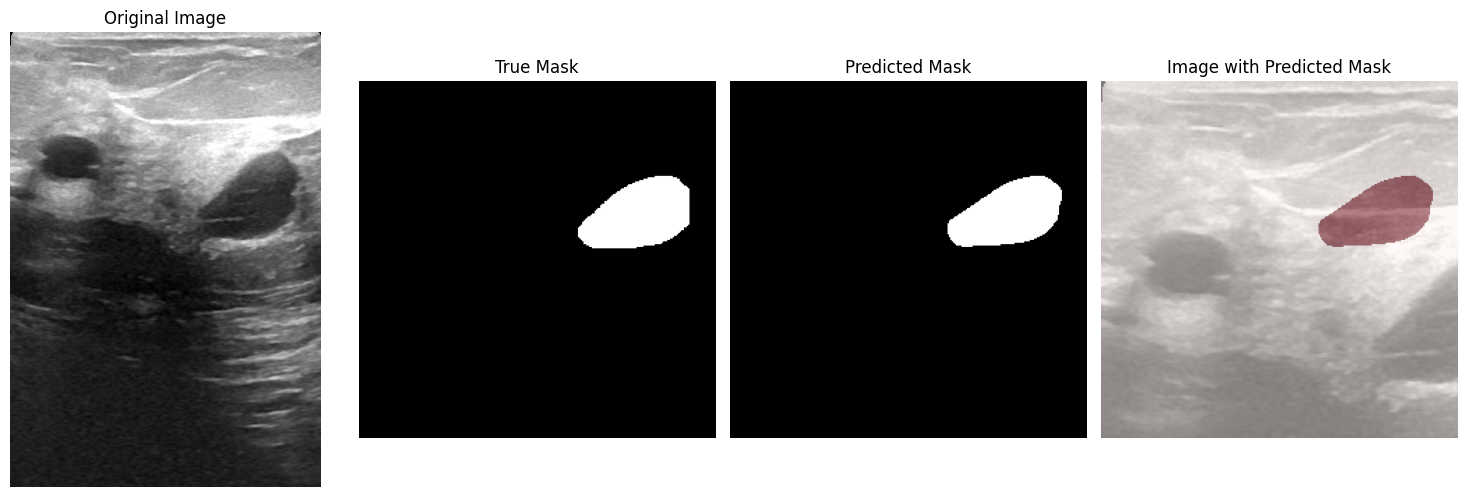

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms

# Assuming the trained U-Net model is available as 'model' and moved to 'device'
# Assuming the SegmentationDataset and DataLoader were created with unet_img_size

# Define the path to an example image and its corresponding mask from the dataset
# Replace these paths with the actual paths to an image and its mask you want to test
example_image_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png'
example_mask_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png'

# --- Prediction with U-Net (Segmentation) ---

# Load and preprocess the example image for U-Net
unet_img_size = 256 # Use the same size as used during training
unet_transform = transforms.Compose([
    transforms.Resize((unet_img_size, unet_img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Assuming grayscale images
])

unet_image = Image.open(example_image_path).convert('L') # Grayscale
original_size = unet_image.size # Get original size for potential resizing back
unet_image_tensor = unet_transform(unet_image).unsqueeze(0).to(device) # Add batch dimension and move to device

# Make prediction with U-Net model
model.eval() # Set U-Net model to evaluation mode
with torch.no_grad():
    unet_output = model(unet_image_tensor)
    predicted_mask_tensor = torch.sigmoid(unet_output) > 0.5 # Apply sigmoid and threshold

# Post-process the predicted mask
predicted_mask_np = predicted_mask_tensor.squeeze().cpu().numpy().astype(np.uint8) # Remove batch and channel dims, to numpy, binary


# --- Evaluation (Visual and Quantitative) ---

# Load and preprocess the true mask
true_mask_image = Image.open(example_mask_path).convert('L') # Grayscale
true_mask_np = transforms.Resize((unet_img_size, unet_img_size))(true_mask_image)
true_mask_np = transforms.ToTensor()(true_mask_np).squeeze().cpu().numpy()
true_mask_np = (true_mask_np > 0.5).astype(np.uint8) # Binarize true mask


# Calculate segmentation metrics for this example
example_iou = iou_score(predicted_mask_np, true_mask_np)
example_dice = dice_score(predicted_mask_np, true_mask_np)

print(f"Evaluation for example image ({example_image_path}):")
print(f"  IoU: {example_iou:.4f}")
print(f"  Dice Coefficient: {example_dice:.4f}")

# --- Display Results ---

# Display the original image, true mask, predicted mask, and predicted mask overlay
original_image_display = Image.open(example_image_path).convert('RGB') # Convert to RGB for display
true_mask_display = Image.fromarray(true_mask_np * 255, mode='L') # Convert binary true mask to grayscale image
predicted_mask_display = Image.fromarray(predicted_mask_np * 255, mode='L') # Convert binary predicted mask to grayscale image

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(original_image_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(true_mask_display, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(predicted_mask_display, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(original_image_display)
plt.imshow(predicted_mask_display, cmap='Reds', alpha=0.5) # Overlay predicted mask in red with transparency
plt.title("Image with Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score # Import needed metrics
import matplotlib.pyplot as plt

# Assuming all_masks and all_preds from the previous evaluation are available
# If not, you would need to re-run the evaluation loop to populate them

# Mean IoU and Dice Coefficient (re-calculated or use values from previous run)
# Using the existing iou_score and dice_score functions and all_ious, all_dices lists
# Note: If you run this cell independently, you need to ensure all_ious and all_dices are populated
# For demonstration, let's assume they are available from the previous cell's execution
# If running this cell first, you would need to add the evaluation loop again.
# For clarity and assuming sequential execution after evaluation, I will just print the means.
# If you need the full evaluation loop here, please let me know.

print("Segmentation Model Metrics:")
# Assuming mean_iou and mean_dice are available from cell UlCJ4p_I-dbv's execution
if 'mean_iou' in locals() and 'mean_dice' in locals():
    print(f"  Mean IoU: {mean_iou:.4f}")
    print(f"  Mean Dice Coefficient: {mean_dice:.4f}")
else:
    print("  Mean IoU and Dice Coefficient not available. Please run the evaluation cell first.")


# Pixel-wise Precision and Recall
# These can be calculated from the pixel-wise confusion matrix (cm)
# cm = [[TN, FP], [FN, TP]]
# Assuming cm from cell 1cIjW8Sf9yQi's execution is available
if 'cm' in locals():
    TN, FP, FN, TP = cm.ravel()

    # Avoid division by zero
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0 # Also known as Sensitivity or True Positive Rate

    print(f"  Pixel-wise Precision: {precision:.4f}")
    print(f"  Pixel-wise Recall (Sensitivity): {recall:.4f}")
else:
     print("  Pixel-wise Precision and Recall not available. Please run the pixel-wise evaluation cell first.")

# You could also calculate these directly from all_masks and all_preds
TP = np.sum(np.logical_and(all_preds == 1, all_masks == 1))
FP = np.sum(np.logical_and(all_preds == 1, all_masks == 0))
FN = np.sum(np.logical_and(all_preds == 0, all_masks == 1))
TN = np.sum(np.logical_and(all_preds == 0, all_masks == 0))

# Then calculate precision and recall using TP, FP, FN

Segmentation Model Metrics:
  Mean IoU: 0.5016
  Mean Dice Coefficient: 0.5393
  Pixel-wise Precision: 0.9109
  Pixel-wise Recall (Sensitivity): 0.8590
